## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Бекетов Роман

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

In [26]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [27]:
device

device(type='cuda')

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [4]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [5]:
images_train, labels_train = next(iter(train_loader))

In [6]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

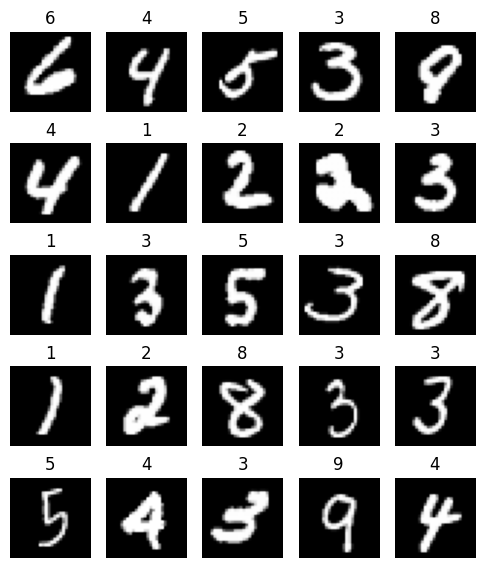

In [7]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

 ## **1. Initialization by xavier and random initialization**

In [8]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [10]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)


layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [14]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

In [15]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9915384650230408
forward 15.888554573059082
backward 0.027080126106739044
backward 0.16946089267730713


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

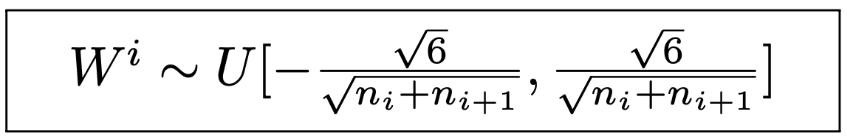

In [16]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    output_size = layer.weight.shape[0]
    input_size = layer.weight.shape[1]
    left_boundary = - np.sqrt(6) / np.sqrt(output_size + input_size)
    right_boundary = - left_boundary
    weight.uniform_(left_boundary, right_boundary)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

In [17]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)


layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

In [18]:
network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

In [19]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 0.9915384650230408
forward 0.6448400616645813
backward 0.027080126106739044
backward 0.011473712511360645


**Сравнение "Xavier с He"**: для симметричных функций активации с нулевым средним (в основном tanh) используют инициализацию Ксавье, а для ReLU и ему подобных — инициализацию Хе.

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

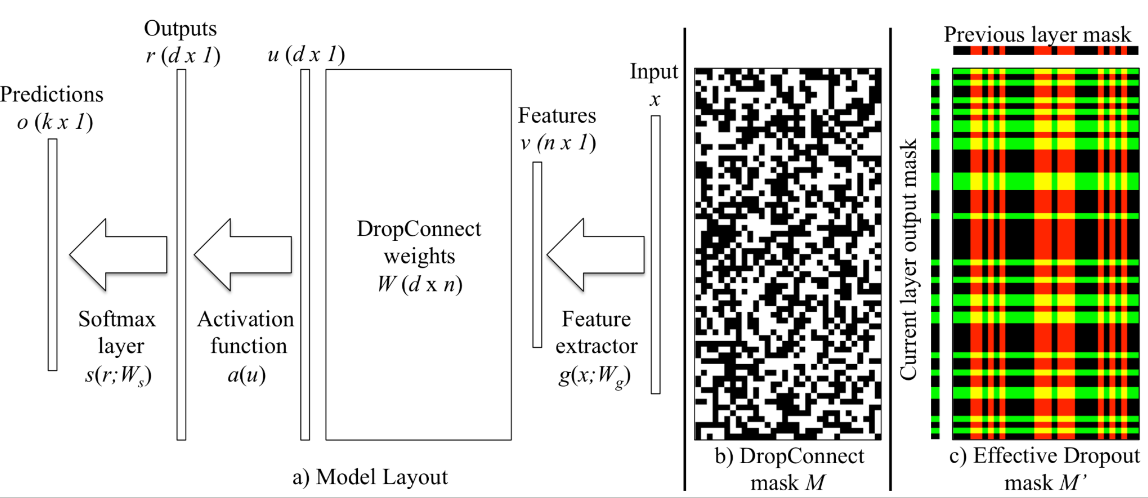

In [42]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.empty(self.linear.weight.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        mask = mask.data.to(device)
        mask.requires_grad=False
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [43]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [44]:
layers = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [45]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

In [46]:
network.to(device)

TestNetwork(
  (conv_layers): Sequential(
    (0): Conv2d(1, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (final_part): Sequential(
    (0): DropConnect(
      (linear): Linear(in_features=196, out_features=128, bias=True)
    )
    (1): ReLU()
    (2): DropConnect(
      (linear): Linear(in_features=128, out_features=128, bias=True)
    )
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)

Обучим получившуюся сеть:

In [51]:
def train(network, optimizer, loss_fn, epoch_size=5, plot=False):
    losses_train = []
    losses_valid = []
    for epoch in range(epoch_size):
        network.train()
        losses_train_batch = []
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            X = images_train.data.to(device)
            y = labels_train.data.to(device)
            output = network(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            
            losses_train_batch.append(loss.cpu().item())
            
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.cpu().item()))
        
        losses_train.append(np.mean(losses_train_batch))

        network.eval()
        losses_valid_batch = []
        for batch_idx, (images_test, labels_test) in enumerate(test_loader):
            X = images_test.data.to(device)
            y = labels_test.data.to(device)
            output = network(X)
            loss = loss_fn(output, y)

            losses_valid_batch.append(loss.cpu().item())

        print('Test Epoch: {}\tLoss: {:.6f}'.format(
                epoch, np.mean(losses_valid_batch)))
        
        losses_valid.append(np.mean(losses_valid_batch))
    
    if plot:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(losses_train, label='Train')
        plt.plot(losses_valid, label='Valid')
        plt.xlabel('Epochs', fontsize=16)
        plt.ylabel('Loss', fontsize=16)
        plt.legend(loc=0, fontsize=16)
        plt.grid('on')
        plt.show()

    return (losses_train, losses_valid)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


Train Epoch: 0 [0/60000 (0%)]	Loss: 0.204777
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.350487
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.278967
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.210670
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.219654
Test Epoch: 0	Loss: 0.219523
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.207840
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.256162
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.195751
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.179421
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.222105
Test Epoch: 1	Loss: 0.168954
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.110386
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.169734
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.087408
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.123708
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.280873
Test Epoch: 2	Loss: 0.151988
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.133622
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.186506
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.155704
Train Epoch: 3 [38400/60000 (64%)

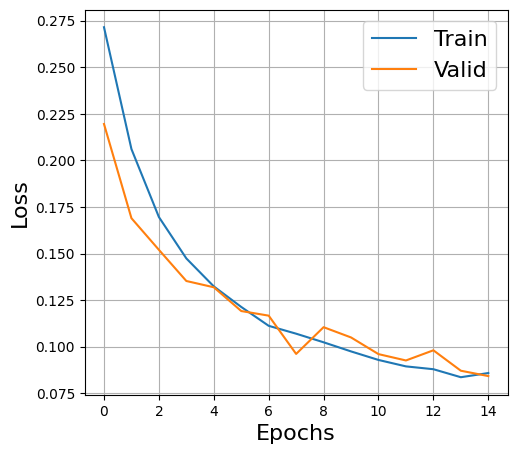

In [52]:
losses_train_dc, losses_valid_dc = train(network, optimizer, loss_fn, epoch_size=15, plot=True)

In [66]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)
        mask = mask.data.to(device)
        return x * mask

In [67]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

In [68]:
network = TestNetwork(nn.Sequential(*layers)).to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.296217
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.954199
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.741171
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.541879
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.475507
Test Epoch: 0	Loss: 0.346889
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.290149
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.452502
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.314575
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.300288
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.371823
Test Epoch: 1	Loss: 0.245451
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.368738
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.235648
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.155102
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.220544
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.184280
Test Epoch: 2	Loss: 0.186340
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.235409
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.272916
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.158319
Train Epoch: 3 [38400/60000 (64%)

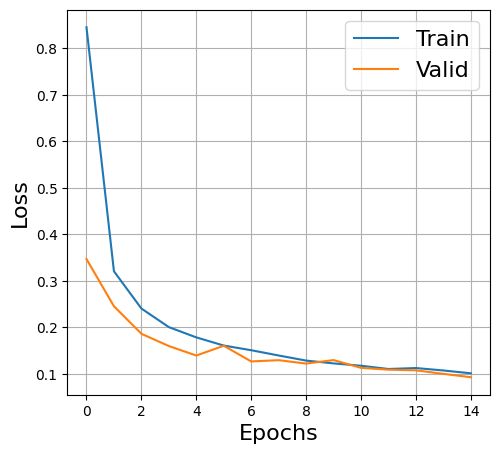

In [69]:
losses_train_do, losses_valid_do = train(network, optimizer, loss_fn, epoch_size=15, plot=True)

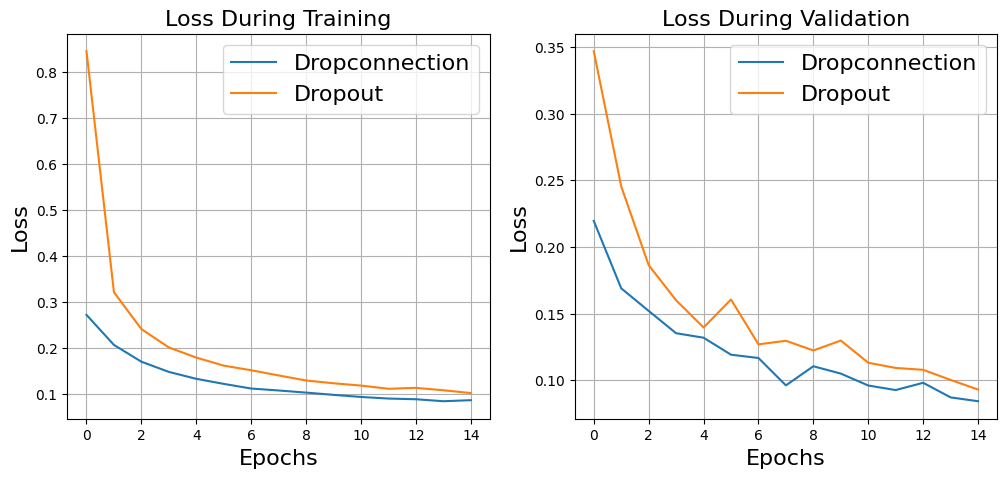

In [70]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_train_dc, label='Dropconnection')
plt.plot(losses_train_do, label='Dropout')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.title('Loss During Training', fontsize=16)
plt.subplot(1, 2, 2)
plt.plot(losses_valid_dc, label='Dropconnection')
plt.plot(losses_valid_do, label='Dropout')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.title('Loss During Validation', fontsize=16)
plt.show()


**Сравнение Dropconnection и Dropout**: На MNISTе Dropconnection показывает себя лучше Dropout с данной архитектурой неройнной сети. Dropconnection - позволяет "создать" еще больше возможных моделей, поскольку соединений почти всегда больше, чем единиц измерения. 

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

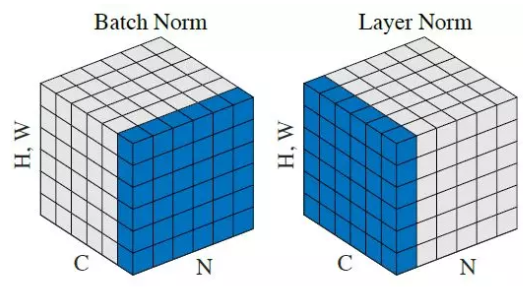

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [78]:
class LayerNormalization(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super(LayerNormalization, self).__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(normalized_shape)).to(device)
        self.beta = nn.Parameter(torch.zeros(normalized_shape)).to(device)
        self.dim = list(range(1,len(normalized_shape)+1))

    def forward(self, x):
        mean = x.mean(dim=self.dim, keepdim=True)
        variance = x.var(dim=self.dim, unbiased=False, keepdim=True)
        x_normalized = (x - mean) / torch.sqrt(variance + self.eps)
        x_normalized = self.gamma * x_normalized + self.beta
        return x_normalized

In [79]:
class TestNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        channels = 1

        self.layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            LayerNormalization([2, 28, 28]),
            nn.MaxPool2d(2),
            nn.ReLU(),

            nn.Conv2d(2, 4, 3, padding=1),
            LayerNormalization([4, 14, 14]),
            nn.MaxPool2d(2),
            nn.ReLU(),
    
            nn.Flatten(),
            nn.Linear(196, 128),
            LayerNormalization([128]),
            nn.ReLU(),

            nn.Linear(128, 128),
            LayerNormalization([128]),
            nn.ReLU(),

            nn.Linear(128, 10)
        )
        
        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.layers(x)
        return self.log_softmax(x)

In [80]:
network = TestNetwork().to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.393174
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.296575
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.122549
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.061379
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.087930
Test Epoch: 0	Loss: 0.111854
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.205710
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.039248
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.164864
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.067765
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.044029
Test Epoch: 1	Loss: 0.089664
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.191919
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.133237
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.043590
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.079436
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.041357
Test Epoch: 2	Loss: 0.081771
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.082728
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.012410
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.027016
Train Epoch: 3 [38400/60000 (64%)

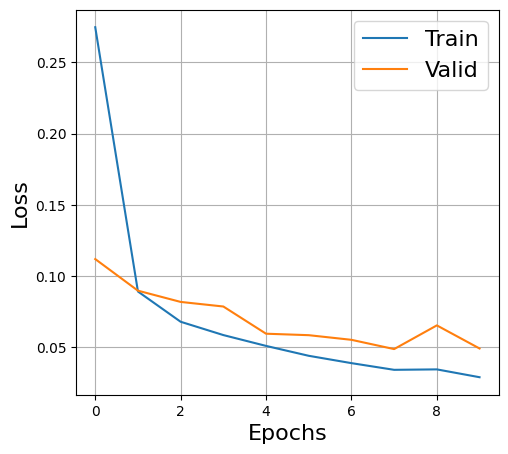

In [81]:
losses_train_ln, losses_valid_ln = train(network, optimizer, loss_fn, epoch_size=10, plot=True)

In [163]:
class BatchNormalization(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, dimensions=1):
        super(BatchNormalization, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.__set_dim(dimensions)

        self.gamma = nn.Parameter(torch.ones(self.view_size)).to(device)
        self.beta = nn.Parameter(torch.zeros(self.view_size)).to(device)
        self.register_buffer('running_mean', torch.zeros(self.view_size))
        self.register_buffer('running_var', torch.ones(self.view_size))

    def __set_dim(self, dim):
        if dim == 1:
            self.dim = 0
            self.view_size = self.num_features
        elif dim == 2:
            self.dim = (0, 2, 3)
            self.view_size = (1, self.num_features, 1, 1)
        else:
            raise RuntimeError("An unsupported dimension is introduced")
        
    def forward(self, x):
        if self.training:
            mean = x.mean(dim=self.dim, keepdim=True)
            variance = x.var(dim=self.dim, unbiased=False, keepdim=True)

            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * variance
        else:
            mean = self.running_mean
            variance = self.running_var

        x_normalized = (x - mean) / torch.sqrt(variance + self.eps)
        x_normalized = x_normalized = self.gamma * x_normalized + self.beta
        return x_normalized


In [164]:
class TestNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        channels = 1

        self.layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            BatchNormalization(num_features=2, dimensions=2),
            nn.MaxPool2d(2),
            nn.ReLU(),

            nn.Conv2d(2, 4, 3, padding=1),
            BatchNormalization(num_features=4, dimensions=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
    
            nn.Flatten(),
            nn.Linear(196, 128),
            BatchNormalization(num_features=128, dimensions=1),
            nn.ReLU(),

            nn.Linear(128, 128),
            BatchNormalization(num_features=128, dimensions=1),
            nn.ReLU(),

            nn.Linear(128, 10)
        )
        
        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.layers(x)
        return self.log_softmax(x)

In [165]:
network = TestNetwork().to(device)
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.477624
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.252020
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.277562
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.132083
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.118709
Test Epoch: 0	Loss: 0.099292
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.153461
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.075659
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.146105
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.041017
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.153162
Test Epoch: 1	Loss: 0.074728
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.055740
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.047855
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.146723
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.105569
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.136263
Test Epoch: 2	Loss: 0.065142
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.044098
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.044670
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.030871
Train Epoch: 3 [38400/60000 (64%)

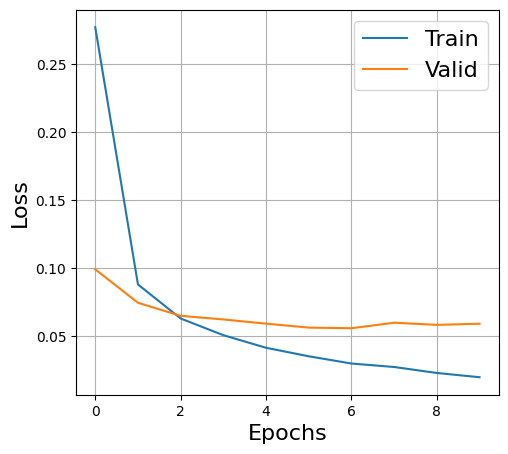

In [166]:
losses_train_bn, losses_valid_bn = train(network, optimizer, loss_fn, epoch_size=10, plot=True)

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

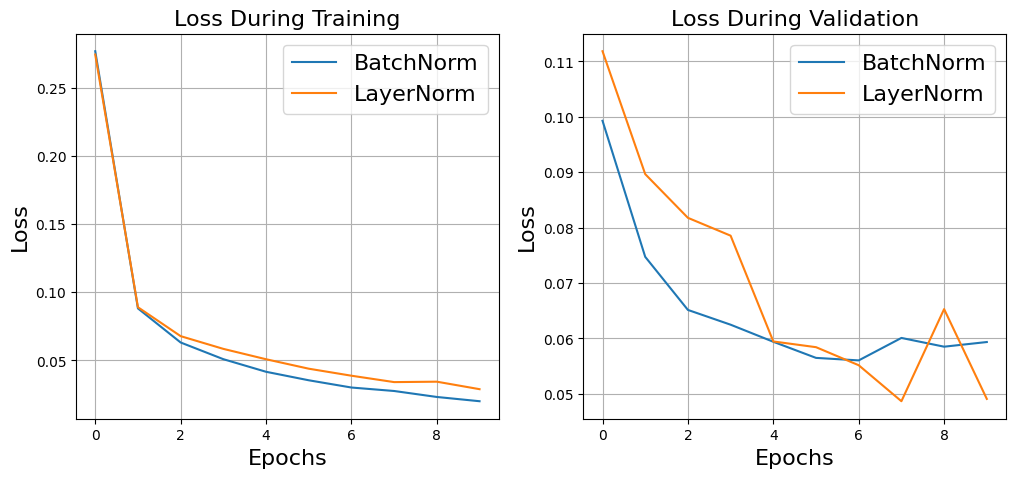

In [167]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_train_bn, label='BatchNorm')
plt.plot(losses_train_ln, label='LayerNorm')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.title('Loss During Training', fontsize=16)
plt.subplot(1, 2, 2)
plt.plot(losses_valid_bn, label='BatchNorm')
plt.plot(losses_valid_ln, label='LayerNorm')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.title('Loss During Validation', fontsize=16)
plt.show()

**Сравнение BatchNorm и LayerNorm**: LayerNorm показал немного лучше результаты на валидации, однако весомой разницы замечено не было. На мнисте с архитектурой CNN разница BatchNorm и LayerNorm прослеживаться скорее всего не будет, однако LayerNorm позволяет решать проблему ковариационного сдвига в RNN архитектурах, а которых BatchNorm бессилен. Также BatchNorm нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. В случае BatchNorm мы считаем статистики по каждой фиче в пределах мини-батча, а в случае LayerNorm, по кажому сэмплу, поэтому LayerNorm не делает элементы батча зависимыми.

## **BatchNorm**
![](https://cdn.sanity.io/images/vr8gru94/production/409b7645d3bdc19d267f6a6bea3bbf75f70636f7-800x535.png)

## **LayerNorm**
![](https://cdn.sanity.io/images/vr8gru94/production/567b2a2d454f2da286ce3cbbe6ce4583a1e2417f-800x627.png)

[Источник картинок](https://www.pinecone.io/learn/batch-layer-normalization/)

### Тест my LayerNorm

In [183]:
EPS_ = 1e-6
# Image Example
N, C, H, W = 20, 5, 10, 10
input = torch.randn(N, C, H, W).to(device)
# Normalize over the last three dimensions (i.e. the channel and spatial dimensions)
# as shown in the image below
layer_norm = nn.LayerNorm([C, H, W]).to(device)
my_layer_norm = LayerNormalization([C, H, W]).to(device)
output = layer_norm.forward(input)
my_output = my_layer_norm.forward(input)
print(output[0][0] - my_output[0][0] < EPS_)

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]],
       device='cuda:0')


### Тест my BatchNorm

In [191]:
EPS_ = 1e-6

input = torch.randn(20, 100, 10, 10).to(device)

batch_layer = nn.BatchNorm2d(100).to(device)
my_batch_layer = BatchNormalization(num_features=100, dimensions=2).to(device)

output = batch_layer(input)
my_output = my_batch_layer(input)
print(output[0][0] - my_output[0][0] < EPS_)

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]],
       device='cuda:0')
